# Viewing Segmentations

Attempt to view the segmentation mask for qualitative evaluation across the 5 classes 
required for this problem. Locations for each should be specified in a list so that it is 
easily extensible. The function will be specific enough as to specify the location of the 
prediction, and the slice.

Given a folder with raw data, the ground truth segmentations also supply a dictionary of
file locations with other model predictions 

## Setup

In [1]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
from utils.environment import setup_data_vars
import matplotlib.pyplot as plt
from matplotlib import transforms
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import cv2
import os
import re
from scipy import ndimage
import itertools
import shutil
import random

setup_data_vars()

In [3]:
def get_id_from_path(path, needs_num=True, pos = 0):
    # Assume that it is the full path that points to the file name. The file name should
    # contain a number indicating the id number. It should appear first
    numbers = re.findall('\d+', os.path.basename(path))
    if needs_num and len(numbers) == 0:
        raise ValueError(f"Could not find a number in {path}")
    if not needs_num and len(numbers) <= pos:
        return 0
    return int(numbers[pos])

In [4]:
assert get_id_from_path('radiotherapy/data/MedSAM_preprocessed/imgs/axis0/CT_zzAMLART_001-071.npy', False) == 1
assert get_id_from_path('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/Bladder/axis0/CT_Bladder_zzAMLART_002-085.npy', False) == 2
assert get_id_from_path('radiotherapy/data/nnUNet_raw/Dataset001_Anorectum/imagesTr/zzAMLART_003_0000.nii.gz', False) == 3
assert get_id_from_path('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/research/source/code/data/reports/reportAnorectum_axis0_1.png', False, pos=1) == 1

In [5]:
def get_slice_from_path(path, isMedSAM = False):
    # Assume that it is the full path that points to the file name. The file name should
    # contain a number indicating the id number. It should appear first. The second number
    # should be slice number
    if 'MedSAM' not in path and not isMedSAM:
        raise ValueError(f'Function intended for getting slice id from a path, which is only characteristic of MedSAM data')
    numbers = re.findall('\d+', path.split('/')[-1])
    assert len(numbers) == 2, f"Could not find a number in {path}"
    return int(numbers[1])

In [6]:
assert get_slice_from_path('radiotherapy/data/MedSAM_preprocessed/imgs/axis0/CT_zzAMLART_001-071.npy') == 71
assert get_slice_from_path('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/Bladder/axis0/CT_Bladder_zzAMLART_002-085.npy') == 85
try: 
    get_slice_from_path('radiotherapy/data/nnUNet_raw/Dataset001_Anorectum/imagesTr/zzAMLART_003_0000.nii.gz')
    assert False, 'Didn\'t raise error as expected'
except ValueError as e: assert str(e) == 'Function intended for getting slice id from a path, which is only characteristic of MedSAM data'

In [7]:
def img_to_gt_path_converter(img_path, anatomy):
    # Given an image path, convert it to the corresponding ground truth path
    # This is only for MedSAM data
    assert 'MedSAM' in img_path, 'Function intended for MedSAM data only'

    # Get the id and slice number
    id = get_id_from_path(img_path)
    s = get_slice_from_path(img_path)
    ax = img_path.split('axis')[1][0]

    # Get the corresponding ground truth path
    return os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', anatomy, f'axis{ax}', f'CT_{anatomy}_zzAMLART_{str(id).zfill(3)}-{str(s).zfill(3)}.npy')

In [8]:
assert img_to_gt_path_converter('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/imgs/axis0/CT_zzAMLART_001-125.npy', 'CTVn') == '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/CTVn/axis0/CT_CTVn_zzAMLART_001-125.npy'
assert img_to_gt_path_converter('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/imgs/axis0/CT_zzAMLART_111-222.npy', 'CTVn') == '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/CTVn/axis0/CT_CTVn_zzAMLART_111-222.npy'

In [9]:
def gt_to_img_path_converter(img_path):
    # Given an image path, convert it to the corresponding ground truth path
    # This is only for MedSAM data
    assert 'MedSAM' in img_path, 'Function intended for MedSAM data only'

    # Get the id and slice number
    id = get_id_from_path(img_path)
    s = get_slice_from_path(img_path)
    ax = img_path.split('axis')[1][0]

    # Get the corresponding ground truth path
    return os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs', f'axis{ax}', f'CT_zzAMLART_{str(id).zfill(3)}-{str(s).zfill(3)}.npy')

In [10]:
assert gt_to_img_path_converter('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/CTVn/axis0/CT_CTVn_zzAMLART_001-125.npy') == '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/imgs/axis0/CT_zzAMLART_001-125.npy'
assert gt_to_img_path_converter('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/CTVn/axis0/CT_CTVn_zzAMLART_111-222.npy') == '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/imgs/axis0/CT_zzAMLART_111-222.npy'

## Plotting Segmentation

In [135]:
def plot_segmentations(
        anatomy : str,
        segmentation_axis : int,
        predictions_path : dict = None,
        slice_dict : dict = None,
        base_raw_data_path = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs'),
        base_gt_data_path = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts'),
        subset = None,
        save_report = True,
    ):
    """Generates a grid of each example class and the ground truth with the optional list
    of predictions

    Args:
        anatomy (str): one of 'Anorectum', 'Bladder', 'CTVn', 'CTVp', 'Parametrium',
        'Uterus', 'Vagina'.
        
        segmentation_axis (int): describes which of the axes to disaply the results for.

        predictions_path (dict, optional): a list of paths that point to a list of predicted
        segmentations that other models have predicted 

        slice_dict (dict, optional): Allows for a manual slice dimension for a certain
        slice, e.g. if the default slice given to others is not descriptive enough.
        Defaults to None.
        
        base_raw_data_path (_type_, optional): where the image data lives. Defaults to
        os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs').

        base_gt_data_path (_type_, optional): where the ground truth data lives. Defaults
        to os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts').

        subset (_type_, optional): subset of images to display. Defaults to None.

        save_report (bool, optional): Whether to save the report or just show. Defaults to
        True
    """

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Before proceeding, check that the arguments are valid >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    assert anatomy in ['Anorectum', 'Bladder', 'CTVn', 'CTVp', 'Parametrium', 'Uterus', 'Vagina', 'TotalBinary'], 'Anatomy not recognized.'
    assert segmentation_axis in [0, 1, 2], 'Axis should be between 0 and 2 inclusive (for the 3 dimensions)'

    # Construct paths to the image data
    if 'MedSAM' not in base_raw_data_path and 'MedSAM' not in base_gt_data_path:
        raise NotImplementedError('We assume that we only have MedSAM pre-processed data. Refer to the old version of this script in the same directory for something that runs for other sources of ground truth and image data.')

    anatomy_img_path = os.path.join(base_raw_data_path, f'axis{segmentation_axis}')
    anatomy_gt_path = os.path.join(base_gt_data_path, anatomy, f'axis{segmentation_axis}')

    assert os.path.isdir(anatomy_img_path),\
          f"{anatomy_img_path} is not a valid directory for Raw Data"
    assert os.path.isdir(anatomy_gt_path),\
          f"{anatomy_gt_path} is not a valid directory for Ground Truth labels"
    for p in predictions_path.values(): assert os.path.isdir(p),\
          f"{p} is not a valid directory for additional Predictions"

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Get list of figures  >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>    

    # Assuming that the images and ground truths are MedSAM pre-processed files which are
    # better for pretty printing

    gt_paths = ['' for _ in range(100)] # assume there are 100 samples
    file_list = os.listdir(anatomy_gt_path)
    random.shuffle(file_list)
    for fn in file_list:
        id = get_id_from_path(fn)
        s = get_slice_from_path(fn, True)

        if not fn.endswith('.npy'):
            continue
        if not (subset is None or id in subset):
            continue
        target_slice_for_id = slice_dict.get(id, -1)
        if (target_slice_for_id == -1 and gt_paths[id - 1] == '') or target_slice_for_id == s:
            gt_paths[id - 1] = os.path.join(anatomy_gt_path, fn)

    gt_paths = sorted(gt_paths)[-100 if subset is None else -len(subset):]

    # Get corresponding slices for the ground truth for this anatomy and axis

    image_paths = list(map(gt_to_img_path_converter, gt_paths))

    predicted_samples = [
        [
            os.path.join(prediction, fn) 
            for fn in sorted(os.listdir(prediction)) 
            # if (fn.endswith('.nii.gz')) and (True if subset is None else get_id_from_path(fn) in subset)
            if (fn.endswith('.npz')) and (True if subset is None else get_id_from_path(fn) in subset)
        ] 
        for prediction in predictions_path.values()]
    
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Construct Figure >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    # Define the dimensions of the plot
    ncols = 2 + len(predicted_samples)
    nrows = len(subset) if subset != None else len(image_paths)

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2.5, nrows * 2.5))
    axes = axes.reshape(nrows, ncols)

    img_size = 1024

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Breif stop: define helper functions >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    def put_image_in_right_direction_based_on_axis(array):
        if segmentation_axis == 1 or segmentation_axis == 2:
            # invert the y-axis
            array = np.flipud(array)
        # elif segmentation_axis == 2:
        #     # rotate by 90 degrees clockwise
        #     array = np.rot90(array, k=-1)

        return array

    def get_slice_for_image_path(image_path):
        s = get_slice_from_path(image_path)
        # Define the slices for each axis
        slices = [slice(None)] * 3      # Create a list of slice(None) for all dimensions
        slices[segmentation_axis] = s
        return slices

    def plot_base_image(image_path, i, axes):
        assert 'MedSAM' in image_path, 'Other sources of base image other than MedSAM not currently supported'

        # Read image into numpy array
        image = np.load(image_path)
        # scale image down to 256x256 for faster display
        image = cv2.resize(
            image,
            (img_size, img_size),
            interpolation=cv2.INTER_NEAREST
        )

        image = put_image_in_right_direction_based_on_axis(image)

        # Plot the image into each column
        for j in range(2 + len(predicted_samples)):
            axes[i, j].imshow(image, cmap='gray')
    
    def plot_segmentation(seg_path, i, j, slices):
        if '.npz' in seg_path or '.npy' in seg_path:
            # Read image into numpy array
            array_gt_label = np.load(seg_path)
            if not isinstance(array_gt_label, np.ndarray):
                if 'files' in array_gt_label.__dict__.keys() and 'probabilities' in array_gt_label.files:
                    array_gt_label = array_gt_label['proabability']

        else:
            # Read image into numpy array
            gt_label = sitk.ReadImage(seg_path)
            array_gt_label = sitk.GetArrayFromImage(gt_label)
            array_gt_label = array_gt_label[tuple(slices)]

        print(seg_path, np.unique(array_gt_label))

        array_gt_label = cv2.resize(
            array_gt_label,
            (img_size, img_size),
            interpolation=cv2.INTER_NEAREST
        ).astype(np.int64)

        array_gt_label = put_image_in_right_direction_based_on_axis(array_gt_label)

        print(seg_path, np.unique(array_gt_label))

        # Set transparent background for non-segmented areas
        alpha_mask = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
        axes[i, j].imshow(array_gt_label, alpha=alpha_mask, cmap=cmap)

    def format_chart(axes, column_titles, image_paths):
        # Remove ticks and invert y axis
        for i in range(nrows):
            for ax in axes[i,]:
                ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

        # Set titles for each column
        for ax, title in zip(axes[0], column_titles):
            ax.set_title(title)

        # Set y labels for each row
        for ax, title in zip(axes[:,0], image_paths):
            id = get_id_from_path(title)
            slice_num = get_slice_from_path(title)
            ax.set_ylabel(f'Sample {id} (axis {segmentation_axis}={slice_num})')

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Create a colour scheme >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    cmap = 'viridis'
    num_cases = 2 ** 7

    # Generate a custom colormap with vibrant colors for segmentation IDs
    color_linspace = plt.cm.tab20(np.linspace(0, 1, num_cases))
    color_linspace[0] = [0, 0, 0, 1]  # Set the background color to black
    cmap = plt.cm.colors.ListedColormap(color_linspace)

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Plot Figure >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    # For each patient example plot the raw data, ground truth and predictions
    for i, (img, gt, pred) in tqdm(enumerate(itertools.zip_longest(image_paths, gt_paths, [*itertools.zip_longest(*predicted_samples)]))):
        slices = get_slice_for_image_path(img)

        # Plot the base image  
        plot_base_image(img, i, axes)

        # Plot the ground truth segmentation
        plot_segmentation(gt, i, 1, slices)

        # Plot the predictions
        for j, p in enumerate(pred):
            if p is not None:
                plot_segmentation(p, i, j + 2, slices)
            else:
                axes[i, j + 2].cla()

    # Format the axis
    format_chart(axes, column_titles=['Raw Data', 'Ground Truth'] + list(predictions_path.keys()), image_paths=image_paths)        

    number = max([0] + [get_id_from_path(fn, False, pos=1) for fn in os.listdir('reports/') if fn.startswith(f'report{anatomy}_axis{segmentation_axis}')])
    plt.suptitle(f"Segmentation for class {anatomy} (Report {number + 1})", y = 1)
    plt.tight_layout()

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Saving and Viewing the Report >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    if save_report:

        file_name = lambda num: f'report{anatomy}_axis{segmentation_axis}_{num}.png'

        try:
            os.makedirs('reports/old', exist_ok=True)
            shutil.move(f'reports/{file_name(number)}', f'reports/old/')
        except FileNotFoundError as e:
            print(f'WARNING: {e}')
        
        plt.savefig(f'reports/{file_name(number + 1)}', bbox_inches='tight')
        plt.clf()
    else:
        plt.show()


In [136]:
from typing import List


def draw_segmentations(class_id: int, subset: List[int] = None, axis = 1, save=True):
    """Prints a plot of the segmentations for the given class in the predefined format.
    This method acts in a factory pattern to generate the plot for each class. 

    Args:
        class_id (int): 1: Anorectum ... 5: Parametrium 
        
        subset (List[int], optional): A subset of the data to display. If None draws all.
        Defaults to None.

        axis (int, optional): The axis to slice the data. Defaults to 1.

        save (bool, optional): Whether to save the report. Defaults to True.
    """

    setup_data_vars()

    classes = [os.environ.get('Anorectum')
             , os.environ.get('Bladder')
             , os.environ.get('CTVn')
             , os.environ.get('CTVp')
             , os.environ.get('Parametrium')
             , os.environ.get('Uterus')
             , os.environ.get('Vagina')
             , os.environ.get('TotalBinary')]

    anorectum = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Anorectum'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'nnUNet (50 eps)': os.path.join(os.environ.get('OLD_DIR'), 'data', 'nnUNet_inference', os.environ.get('Anorectum'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Anorectum'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'MedSAM': os.path.join(os.environ.get('MedSAM_results'), 'Anorectum'),
    }

    bladder = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Bladder'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'nnUNet (50 eps)': os.path.join(os.environ.get('OLD_DIR'), 'data', 'nnUNet_inference', os.environ.get('Bladder'), 'imagesTr_3dhighres'),
        'total segmentator': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Bladder'), 'nnUNetTrainer__nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Bladder'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        # 'MedSAM': os.path.join(os.environ.get('MedSAM_results'), 'Bladder'),
    }

    ctvn = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVn'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'nnUNet (50 eps)': os.path.join(os.environ.get('OLD_DIR'), 'data', 'nnUNet_inference', os.environ.get('CTVn'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('CTVn'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        # 'MedSAM': os.path.join(os.environ.get('MedSAM_results'), 'CTVn'),   
    }

    ctvp = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVp'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'nnUNet (50 eps)': os.path.join(os.environ.get('OLD_DIR'), 'data', 'nnUNet_inference', os.environ.get('CTVp'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('CTVp'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        # 'MedSAM': os.path.join(os.environ.get('MedSAM_results'), 'CTVp'),
    }

    parametrium = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Parametrium'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'nnUNet (50 eps)': os.path.join(os.environ.get('OLD_DIR'), 'data', 'nnUNet_inference', os.environ.get('Parametrium'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Parametrium'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        # 'MedSAM': os.path.join(os.environ.get('MedSAM_results'), 'Parametrium'),
    }

    uterus = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Uterus'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'nnUNet (50 eps)': os.path.join(os.environ.get('OLD_DIR'), 'data', 'nnUNet_inference', os.environ.get('Uterus'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Uterus'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        # 'MedSAM': os.path.join(os.environ.get('MedSAM_results'), 'Uterus'),
    }

    vagina = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Vagina'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'nnUNet (50 eps)': os.path.join(os.environ.get('OLD_DIR'), 'data', 'nnUNet_inference', os.environ.get('Vagina'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Vagina'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        # 'MedSAM': os.path.join(os.environ.get('MedSAM_results'), 'Vagina'),
    }

    totalbinary = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres_flattened')
    }

    predictions = [anorectum, bladder, ctvn, ctvp, parametrium, uterus, vagina, totalbinary]

    slice_axes_per_class = [
          [{}, {4: 280, 6: 290, 100: 280, 94: 311}, {}] # Anorectum
        , [{}, {}, {}]                                  # Bladder
        , [{}, {}, {}]                                  # CTVn
        , [{}, {}, {}]                                  # CTVp
        , [{}, {}, {}]                                  # Parametrium
        , [{}, {}, {}]                                  # Uterus
        , [{}, {}, {}]                                  # Vagina
        , [{}, {1: 300}, {}]                            # TotalBinary
    ]

    if 1 <= class_id <= len(predictions):
        index = class_id - 1
        anatomy = list(map(lambda x: x.split('_')[1], classes))[index]
        slices_dict = slice_axes_per_class[index][axis]

        plot_segmentations(
            anatomy = anatomy,
            segmentation_axis = axis,
            predictions_path = predictions[index],
            slice_dict = slices_dict,
            subset = subset,
            save_report = save)
    else:
        raise ValueError("Invalid class_id. Please choose a class between 1 and 5.")

0it [00:00, ?it/s]


/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed_lowres/gts/TotalBinary/axis1/CT_TotalBinary_zzAMLART_001-300.npy [ 0  1  3  5 20 60]
/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed_lowres/gts/TotalBinary/axis1/CT_TotalBinary_zzAMLART_001-300.npy [ 0  1  3  5 20 60]


KeyError: 'proabability is not a file in the archive'

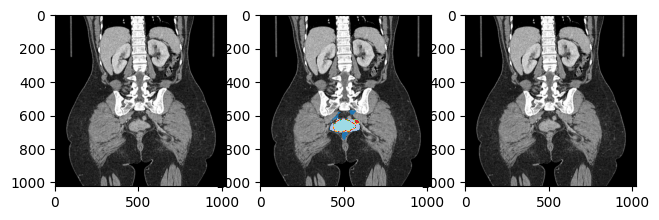

In [137]:
draw_segmentations(8, subset = [1], axis=1, save=False)

In [ ]:
# for i in range(1, 8):
#     for a in range(3):
#         if i <= 4 and a == 1 or a == 0:
#             continue # this has been displayed properly
#         try:
#             print(f"Drawing for class {i} and axis {a}")
#             draw_segmentations(i, axis=a, save=True)
#         except Exception as e:
#             print(f"Error for class {i} and axis {a}: {e}")